In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [29]:
plt.style.use('ggplot')

In [30]:
df=pd.read_csv('SeoulBikeData.csv',encoding='latin-1')

In [31]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [32]:
df['Date']=pd.to_datetime(df['Date'])

In [33]:
df=df.sort_values('Date')

In [34]:
df.isna().sum().sum()

0

In [35]:
df['Year']=df['Date'].dt.year
df['Month']=df['Date'].dt.month
df['WeekDay']=df['Date'].dt.weekday

In [36]:
df['WeekDay']=df['WeekDay'].apply(lambda x:'workday' if x<=4 else 'weekend')

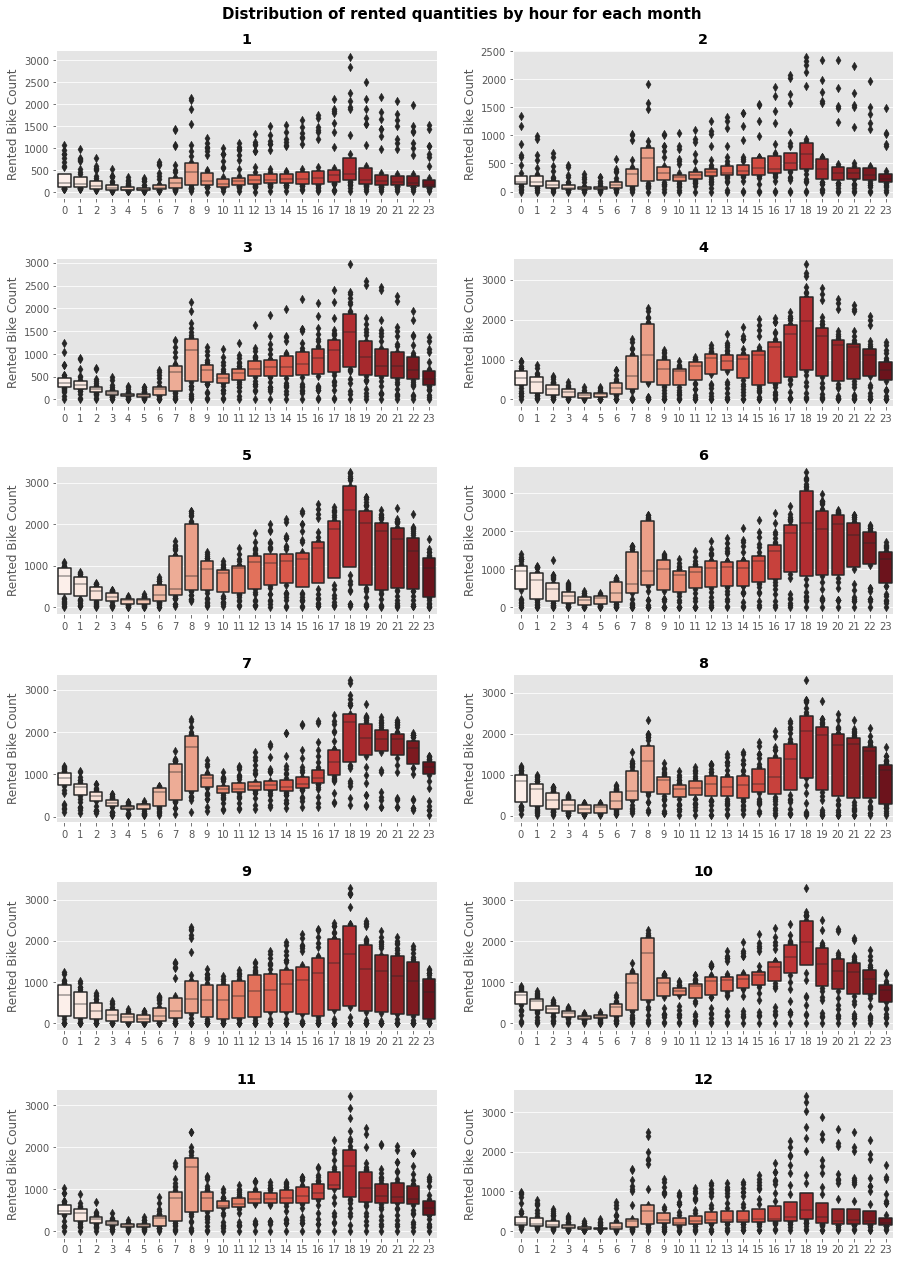

In [37]:
fig,axes=plt.subplots(6,2, figsize=(15,20))

for ax,month in zip(axes.ravel(),df['Month'].unique()):
    filtered=df[df['Month']==month]
    sns.boxenplot(ax=ax,data=filtered,x='Hour',y='Rented Bike Count',palette='Reds')
    ax.set_title(month,fontweight='bold')
    ax.set_xlabel('')
plt.suptitle('Distribution of rented quantities by hour for each month',size=15,fontweight='bold')
plt.subplots_adjust(hspace=0.4,top=0.95)
plt.show()

In [38]:
# median rented quantities differ according to month

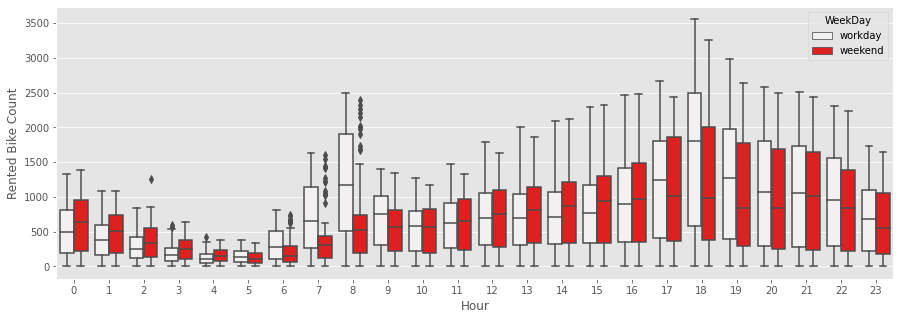

In [39]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df,x='Hour',y='Rented Bike Count',hue='WeekDay',color='r')
plt.show()

In [40]:
# bike sharing is high on workdays at 7,8,9 and 10 AM. People might be using bikes as an alternative to other transportation types to go to work.
# the same way bike sharing is high at 6,7,8 and 9 PM on working days. People use bikes to go to home from work.
# at othe time period of a day bike sharing is higher on weekends.

In [41]:
df.corr()['Rented Bike Count'].sort_values(ascending=False)

Rented Bike Count            1.000000
Temperature(°C)              0.538558
Hour                         0.410257
Dew point temperature(°C)    0.379788
Solar Radiation (MJ/m2)      0.261837
Year                         0.215162
Visibility (10m)             0.199280
Wind speed (m/s)             0.121108
Month                        0.070861
Rainfall(mm)                -0.123074
Snowfall (cm)               -0.141804
Humidity(%)                 -0.199780
Name: Rented Bike Count, dtype: float64

In [42]:
df=df[df['Functioning Day']=='Yes']

df=df.drop(columns=['Functioning Day'])

In [43]:
for col in df.select_dtypes('O').columns:
    dummies=pd.get_dummies(df[col],prefix=col)
    df=df.drop(columns=col)
    df=pd.concat([df,dummies],axis=1)

In [44]:
train=df[df['Date']<'2018-11-01']
test=df[df['Date']>='2018-11-01']

xtrain,xtest,ytrain,ytest=train.drop(columns=['Date','Rented Bike Count']),test.drop(columns=['Date','Rented Bike Count']),train['Rented Bike Count'],test['Rented Bike Count']

In [45]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [46]:
#model=XGBRegressor()
#params={ 'learning_rate':[0.01,0.02,0.05], 'max_depth':[2,3,5], 'n_estimators':[1000,2000] }
#gs=GridSearchCV(model,params,n_jobs=1,verbose=10,cv=3)

#gs.fit(xtrain,ytrain)

In [47]:
#gs.best_params_
#{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000}

In [48]:
model=XGBRegressor(learning_rate=0.05,max_depth=5,n_estimators=1000)

model.fit(xtrain,ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [49]:
train_prediction=model.predict(xtrain)
test_prediction=model.predict(xtest)

In [50]:
from sklearn import metrics

r2_train=metrics.r2_score(train_prediction,ytrain)
r2_test=metrics.r2_score(test_prediction,ytest)

mae_train=metrics.mean_absolute_error(train_prediction,ytrain)
mae_test=metrics.mean_absolute_error(test_prediction,ytest)

rmse_train=metrics.mean_squared_error(train_prediction,ytrain,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,ytest,squared=False)

print('R2, MAE ,RMSE for train and test data are:')
print(r2_train,r2_test)
print(mae_train,mae_test)
print(rmse_train,rmse_test)

R2, MAE ,RMSE for train and test data are:
0.9753887643166127 0.8149666508748676
64.62430166103898 155.8650444901397
98.95707115436278 224.7223797806777


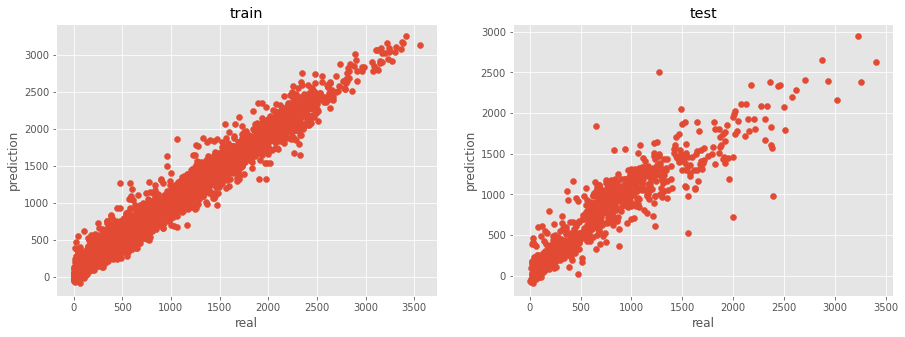

In [51]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(ytrain,train_prediction)
ax1.set_xlabel('real')
ax1.set_ylabel('prediction')
ax1.set_title('train')

ax2.scatter(ytest,test_prediction)
ax2.set_xlabel('real')
ax2.set_ylabel('prediction')
ax2.set_title('test')
plt.show()

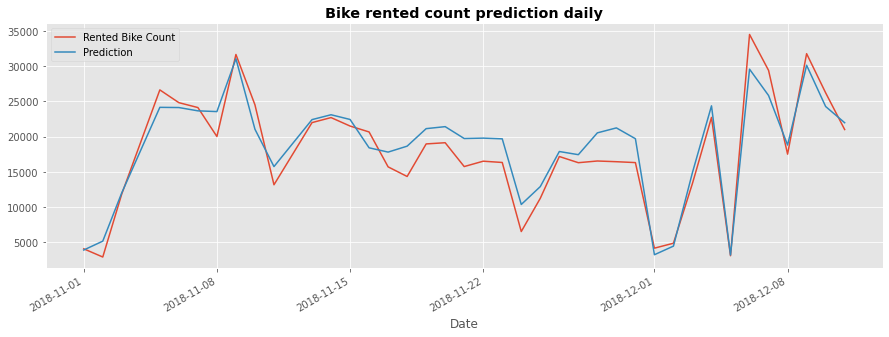

In [52]:
test=test.reset_index(drop=True)
test=pd.concat([test,pd.Series(test_prediction)],axis=1)
test=test.rename(columns={0:'Prediction'})
grouped=test.groupby('Date').sum().reset_index()
grouped.sort_values('Date').plot(figsize=(15,5),x='Date',y=['Rented Bike Count','Prediction'])
plt.title('Bike rented count prediction daily',fontweight='bold')
plt.show()

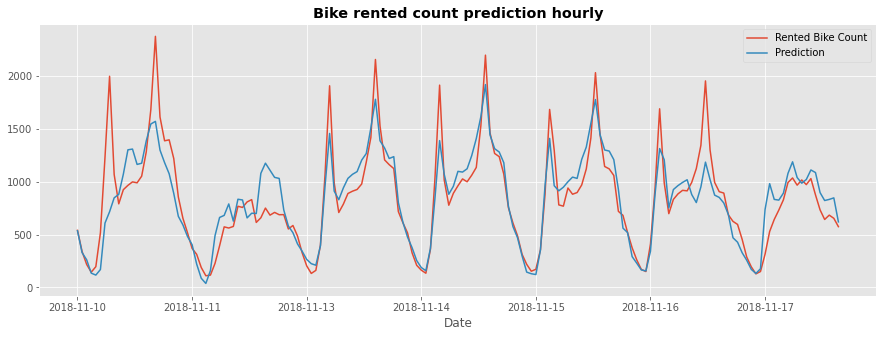

In [53]:
test['Date']=test['Date'].astype(str)
test['Hour']=test['Hour'].astype(str)
test['Datetime']=pd.to_datetime(test['Date']+' '+test['Hour']+':00')

test.query('"2018-11-10"<Datetime<"2018-11-18"').sort_values('Datetime').plot(figsize=(15,5),x='Date',y=['Rented Bike Count','Prediction'])
plt.title('Bike rented count prediction hourly',fontweight='bold')
plt.show()